In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
import os
#import xgboost as xgb
#import lightgbm as lgb
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import gc
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')


/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
os.listdir('dataset-0510/')

['fields.pdf',
 'test.csv',
 'submit_test.csv',
 'train.csv',
 '~$Result.xlsx',
 'Result.xlsx']

In [41]:
train = pd.read_csv('dataset-0510/train.csv')
test  = pd.read_csv('dataset-0510/test.csv')


In [63]:
data = pd.concat([train, test], axis=0)
gc.collect()

7

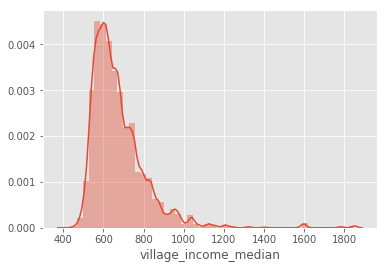

In [4]:
sns.distplot(train[train['village_income_median'].notna()]['village_income_median'])

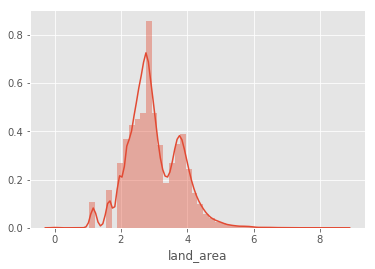

In [5]:
sns.distplot(np.log1p(train['land_area']))

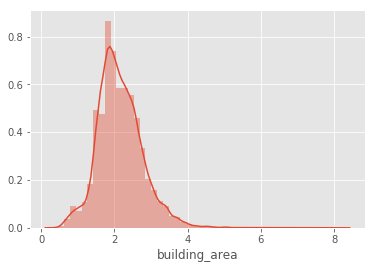

In [6]:
sns.distplot(np.log1p(train['building_area']))

In [7]:
train.loc[train['parking_price'].notna(), 'parking_price'].values.reshape(-1,1)

array([[ 81138.88976205],
       [ 61488.56895029],
       [  6721.82305718],
       ...,
       [ 19290.95373523],
       [133729.22686534],
       [ 61488.56895029]])

In [11]:
lm = LinearRegression()
temp = train.loc[(train['total_price'].notna()) & (train['parking_price'].notna())]
lm.fit(temp['total_price'].values.reshape(-1,1), temp['parking_price'].values.reshape(-1,1))
predict = lm.predict(train.loc[train['parking_price'].isna(), 'total_price'].values.reshape(-1,1))



In [10]:
train['land_area'].isna().sum()

0

In [16]:
train[train['building_type'] == 3][['land_area', 'building_area','parking_area']].head()

,land_area,building_area,parking_area
0,18.144460,3.418175,NaN
7,11.387227,7.974018,NaN
9,11.387227,7.480303,NaN
12,11.387227,5.356788,NaN
17,13.106100,7.974018,NaN


In [64]:
def feature_process(df):
    
    df['min_cat'] = 0
    for col in [i for i in df.columns if 'MIN' in i]:
        df['min_cat'] = df.apply(lambda x : col if x['min_cat'] == x[col] else x['min_cat'], axis=1)
    #Impute missing value
    #df['village_income_median'] = df.groupby(['city', 'town'])['village_income_median'].transform(lambda x : x .fillna(x.median()))
    df['village_income_mean'] = df.groupby(['city', 'town'])['village_income_median'].transform(lambda x : x .fillna(x.mean()))
    
    #floor
    df.loc[df['txn_floor'].isna(), 'department'] = 1 
    df.loc[df['txn_floor'].notna(), 'department'] = 0
    df.loc[df['txn_floor'].isna(), 'txn_floor'] = df.loc[df['txn_floor'].isna(), 'total_floor']
    df['avg_height_floor'] = df['txn_floor'] / df['total_floor'] 
    df['avg_height_floor'].fillna(1, inplace = True)
    
    #village_income_median
    temp = df.groupby(['city', 'town', 'village'])['village_income_median'].first().reset_index()
    temp = df.groupby(['city', 'town']).agg({'village_income_median' : ['mean', 'sum', 'median']})
    temp = temp.rename({'village_income_median_sum' : 'town_income_median_sum'})
    temp.columns = [e[0] + '_' + e[1] if e[1] != '' else e[0] for e in temp.columns.tolist()]
    df = pd.merge(df, temp, on = ['city', 'town'], how = 'left')

    temp = df.groupby(['city', 'town', 'village'])['village_income_median'].first().reset_index()
    temp = df.groupby(['city']).agg({'village_income_median' : ['mean', 'sum', 'median']})
    temp = temp.rename({'village_income_median_sum' : 'city_income_median_sum'})
    temp.columns = [e[0] + '_' + e[1] if e[1] != '' else e[0] for e in temp.columns.tolist()]
    df = pd.merge(df, temp, on = ['city'], how = 'left')
    
    
    
    #location
    #df['location_1'] = df.apply(lambda x : int(str(x['city']) + str(x['town']) + str(x['village'])), axis=1)
    df['location_2'] = df.apply(lambda x : int(str(x['city']) + str(x['town'])), axis=1)
    df['city'] = df['city'].astype('category')
    df['location_2'] = df['location_2'].astype('category')
    
    #date
    df['day_between_txn_complete'] = df['txn_dt'] - df['building_complete_dt']
    df['year_between_txn_complete'] = round(df['day_between_txn_complete'] / 365)
    
    
    #parking
    df['miss_parking_area'] = 0
    df['miss_parking_price'] = 0
    df.loc[df['parking_area'].isna(), 'miss_parking_area'] = 1
    df.loc[df['parking_price'].isna(), 'miss_parking_price'] = 1
    df['parking_price_every_area'] = df['parking_price'] / df['parking_area']
    df['parking_way'] = df['parking_way'].astype('category')
    df = df.join(pd.get_dummies(df['parking_way'], prefix = 'parking_way'))
    df['parking_area'].fillna(0, inplace =True)
    df['parking_price'].fillna(0, inplace =True)
    
    #area
    df['land/bulid_area'] = df['land_area'] / df ['building_area']
    df['house_area'] = df['building_area'] - df['parking_area'] 
    df['house_rate'] = df['building_area'] / df['house_area']
    
    #population
    
    #soical rate
    df['natural_diff'] = df['born_rate'] - df['death_rate']
    df['natural_rate'] = df['born_rate'] / df['death_rate']
    
    df['marry_diff'] = df['marriage_rate'] - df['divorce_rate']
    df['marry_rate'] = df['marriage_rate'] / df['divorce_rate']
    
    df['total_diff_sum'] = df['natural_rate'] + df['marry_diff']
    df['total_diff_diff'] = df['natural_rate'] - df['marry_diff']
    df['total_rate_diff'] = df['born_rate'] + df['marry_rate']
    
    df['positive_grow_rate'] = df['born_rate'] + df['marriage_rate']
    df['negative_grow_rate'] = df['death_rate'] + df['divorce_rate']
    df['tatal_rate_sum'] = df['born_rate'] + df['death_rate'] + df['born_rate'] + df['death_rate']
    
    #building   #building_type = 4 is house
    #df['building_type'] = df['building_type'].astype('category')
    df = df.join(pd.get_dummies(df['building_type'], prefix = 'building_type'))
    #df.drop('building_type', axis = 1, inplace =True)
    df['building_use'] = df['building_use'].astype('category')
    df['building_material'] = df['building_material'].astype('category')
    
    #degree rate
    df['diff_doc_master'] = df['doc_rate'] - df['master_rate']
    df['diff_master_bachelor'] = df['master_rate'] - df['bachelor_rate']
    df['diff_bachelor_highsch'] = df['bachelor_rate'] - df['highschool_rate']
    df['diff_highsch_jobschool'] = df['highschool_rate'] - df['jobschool_rate']
    df['diff_jobschool_elesch'] = df['jobschool_rate'] - df['elementary_rate']
    
    df['all_degree'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] + df['jobschool_rate'] + df['junior_rate'] + df['elementary_rate']
    df['junior_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] + df['jobschool_rate'] + df['junior_rate'] 
    df['jobschool_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] +  df['jobschool_rate']
    df['highschool_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate']
    df['bachelor_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate']
    df['master_above_rate'] = df['doc_rate'] + df['master_rate'] 
    
    #MIN
    MIN_cols = [i for i in df.columns if '_MIN' in i]
    df['MIN_dis_plus'] = reduce(lambda x,y: x + y, [df[i] for i in [i for i in df.columns if '_MIN' in i]])
    

    
    #10 50 100 250 500 1000 5000 10000
    df['diff_500_50'] = df['N_500'] - df['N_50']
    df['diff_1000_500'] = df['N_1000'] - df['N_500']
    df['diff_5000_1000'] = df['N_5000'] - df['N_1000']
    df['diff_10000_5000'] = df['N_10000'] - df['N_5000']
    df['rate_500_50'] = df['N_500'] / df['N_50']
    df['rate_1000_500'] = df['N_1000'] / df['N_500']
    df['rate_5000_1000'] = df['N_5000'] / df['N_1000']
    df['rate_10000_5000'] = df['N_10000'] / df['N_5000']
    
    '''
    All_10    = [i for i in df.columns if i.endswith('_10') and 'index' not in i and 'N' not in i]
    All_50    = [i for i in df.columns if i.endswith('_50') and 'index' not in i and 'N' not in i]
    All_100   = [i for i in df.columns if i.endswith('_100') and 'index' not in i and 'N' not in i]
    All_250   = [i for i in df.columns if i.endswith('_250') and 'index' not in i and 'N' not in i]
    All_500   = [i for i in df.columns if i.endswith('_500') and 'index' not in i and 'N' not in i]
    All_1000  = [i for i in df.columns if i.endswith('_1000') and 'index' not in i and 'N' not in i]
    All_5000  = [i for i in df.columns if i.endswith('_5000') and 'index' not in i and 'N' not in i]
    All_10000 = [i for i in df.columns if i.endswith('_10000') and 'index' not in i and 'N' not in i]
    df['All_10'] = reduce(lambda x, y: x + y, [df[i] for i in All_10])
    df['All_50'] = reduce(lambda x, y: x + y, [df[i] for i in All_50])
    df['All_100'] = reduce(lambda x, y: x + y, [df[i] for i in All_100])
    df['All_250'] = reduce(lambda x, y: x + y, [df[i] for i in All_250])
    df['All_500'] = reduce(lambda x, y: x + y, [df[i] for i in All_500])
    df['All_1000'] = reduce(lambda x, y: x + y, [df[i] for i in All_1000])
    df['All_5000'] = reduce(lambda x, y: x + y, [df[i] for i in All_5000])
    df['All_10000'] = reduce(lambda x, y: x + y, [df[i] for i in All_10000])
    
    for i,j in  zip([All_10, All_50, All_100, All_250, All_500, All_1000, All_5000], [All_50, All_100, All_250, All_500, All_1000, All_5000, All_10000]):
        for order in range(len(i)):
            df[j[order] + '_' + i[order] + '_diff'] = df[j[order]] - df[i[order]]
            df[j[order] + '_' + i[order] + '_rate'] = df[j[order]] / df[i[order]]
    '''
    #interection
    
    
    inter_cols = ['building_type', 'parking_way', 'building_use', 'building_material']
    for i in range(4):
        for j in range(4):
            if j > i:
                df['inter_btw_' + inter_cols[i] +'_' + inter_cols[j]] = df.apply(lambda x : str(x[inter_cols[i]]) + str(x[inter_cols[j]]), axis=1)
                df['inter_btw_' + inter_cols[i] +'_' + inter_cols[j]] = df['inter_btw_' + inter_cols[i] +'_' + inter_cols[j]].astype('category')
    
    
    #groupby encoding
    '''
    category_cols  = ['city', 'location_2', 'building_material',
                      'building_type',
                      'building_use',
                      'city',
                      'parking_way',
                      'inter_btw_building_type_parking_way',
                      'inter_btw_building_type_building_use',
                      'inter_btw_building_type_building_material',
                      'inter_btw_parking_way_building_use',
                      'inter_btw_parking_way_building_material',
                      'inter_btw_building_use_building_material']
    
    numerical_cols = ['building_area', 'land_area', 'day_between_txn_complete', 'txn_dt', 'building_complete_dt', 'house_area', 'house_rate']
    statistics = ['mean', 'median', 'max', 'min']
    for category in category_cols:
        for numerical in numerical_cols:
            for stat in statistics:
                df[numerical + '_' + stat + '_gb_' + category] = df.groupby([category])[numerical].transform(stat)
                df[numerical + '_diff_' + stat + '_gb_' + category] = df[numerical] - df[numerical + '_' + stat + '_gb_' + category]
    
    
    category_cols =['city', 'location_2']
    count_cols = ['building_type', 'building_use', 'building_material', 'parking_way']
    for category in category_cols:
        for count_col in count_cols:
            df['size_gb_' + category + '_' + count_col] = df.groupby([category, count_col])[count_col].transform('size')
    '''
    
    #df['parking_price'] = df.groupby(['building_type', 'parking_way'])['parking_price'].transform(lambda x : x.median())

    
    #Polynomail feature
    
    
    #useless cols
    df.drop(['village', 'town', 'building_type', 'parking_way'], axis = 1, inplace = True)
    df.drop([i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i], axis = 1, inplace = True)
    return df

In [65]:
data = feature_process(data)
FE_train = data[:60000]
FE_test = data[60000:]
FE_train.to_csv('FE_train.csv', index = False)
FE_test.to_csv('FE_test.csv', index = False)
len(FE_train.columns), len(FE_test.columns)

In [67]:
gc.collect()

250

In [1]:
[i for i in FE_train.columns if FE_train[i].dtypes not in ['float', 'int', 'O']]

NameError: name 'FE_train' is not defined

In [62]:
[i for i in FE_train.columns if FE_train[i].dtypes not in ['float', 'int', 'O']]

['building_material',
 'building_type',
 'building_use',
 'city',
 'parking_way',
 'location_2',
 'inter_btw_building_type_parking_way',
 'inter_btw_building_type_building_use',
 'inter_btw_building_type_building_material',
 'inter_btw_parking_way_building_use',
 'inter_btw_parking_way_building_material',
 'inter_btw_building_use_building_material']

In [95]:
FE_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Columns: 932 entries, III_10 to size_gb_location_2_parking_way
dtypes: category(12), float64(570), int64(349), object(1)
memory usage: 422.4+ MB


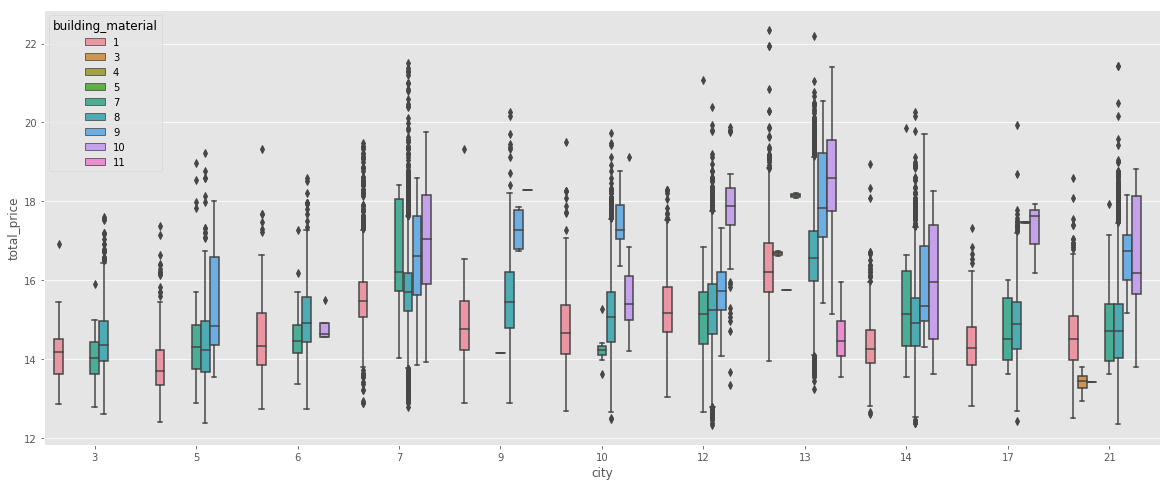

In [26]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = np.log1p(train['total_price']), hue = train['building_material'])

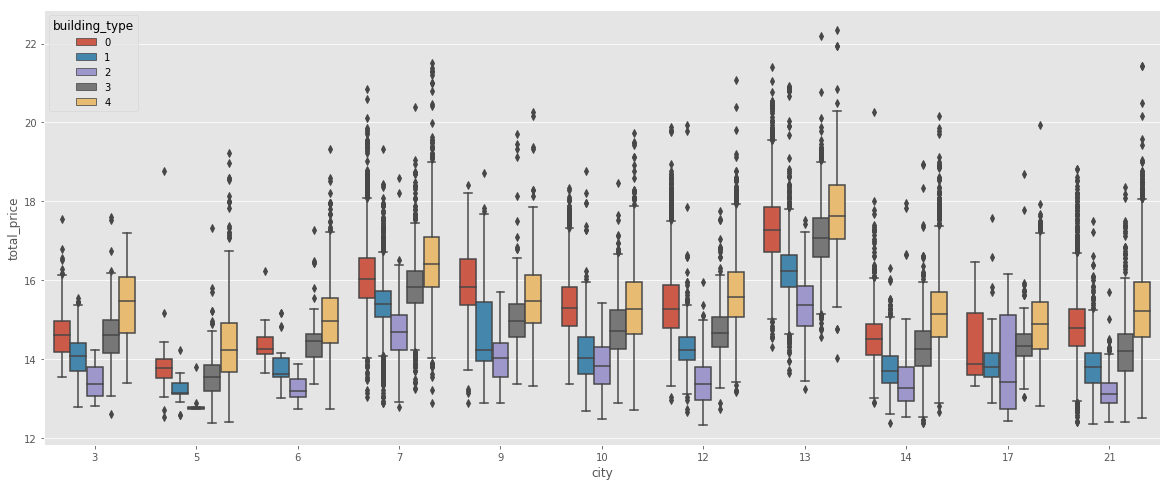

In [81]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = np.log1p(train['total_price']), hue = train['building_type'])

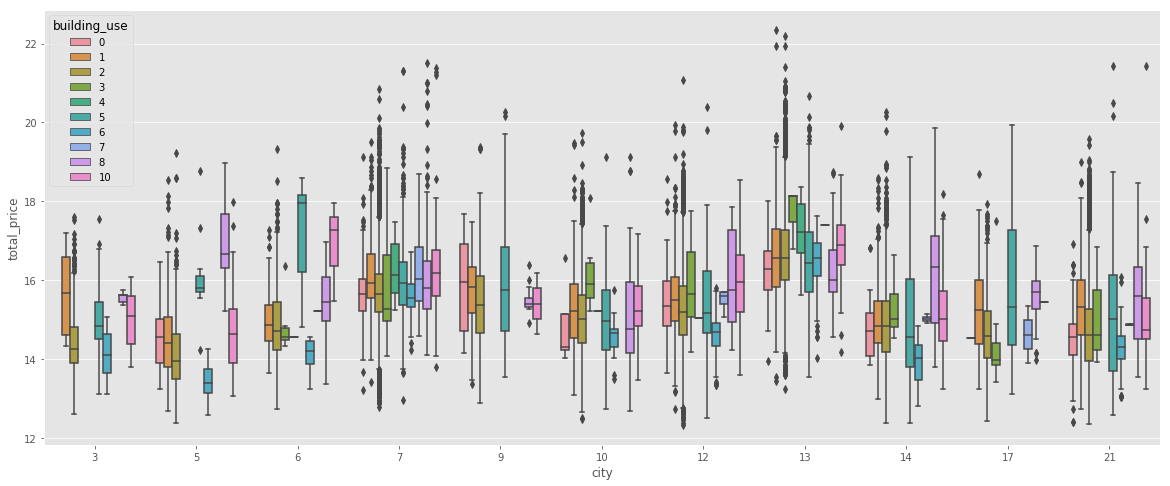

In [82]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = np.log1p(train['total_price']), hue = train['building_use'])

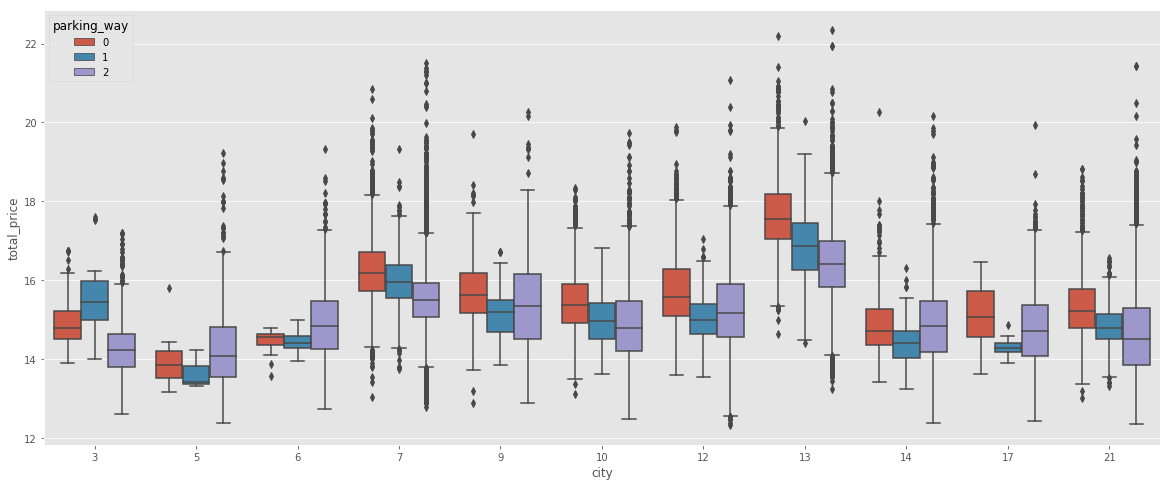

In [83]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = np.log1p(train['total_price']), hue = train['parking_way'])

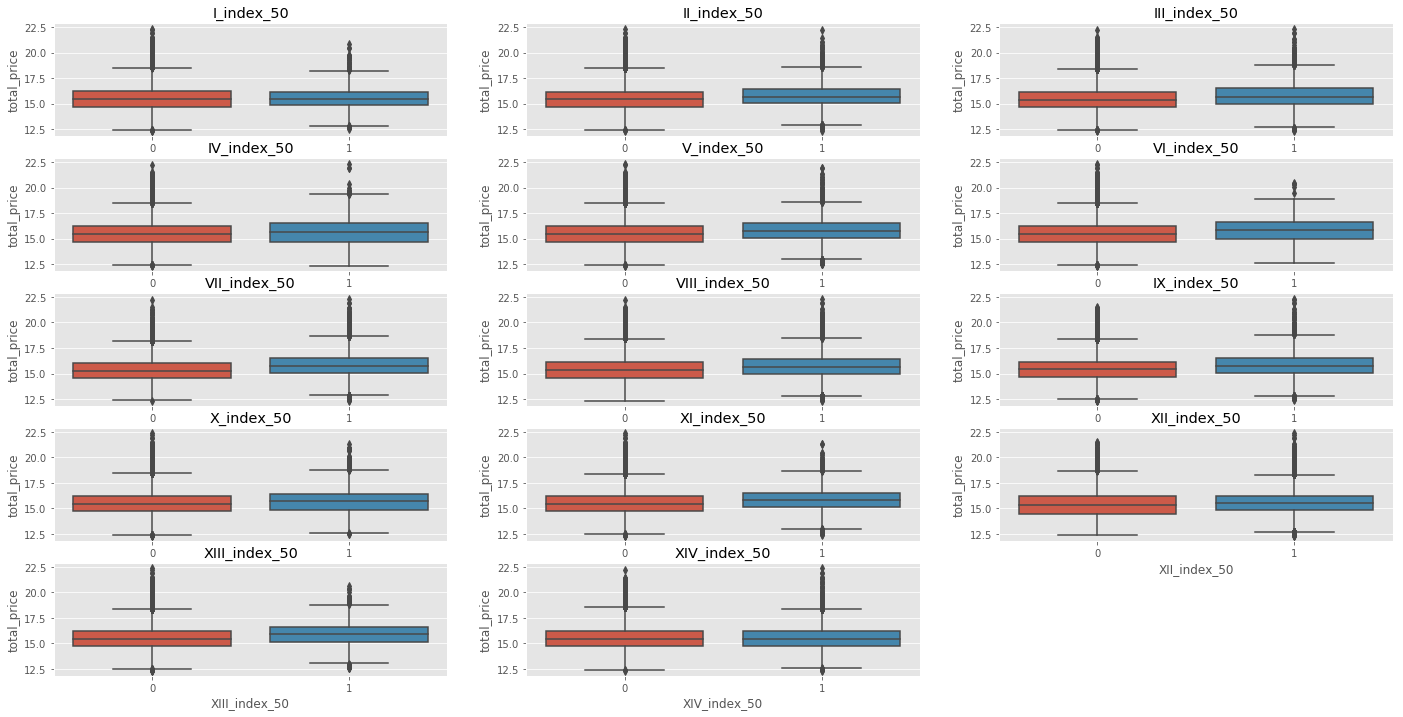

In [27]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_50')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], np.log1p(train['total_price']))

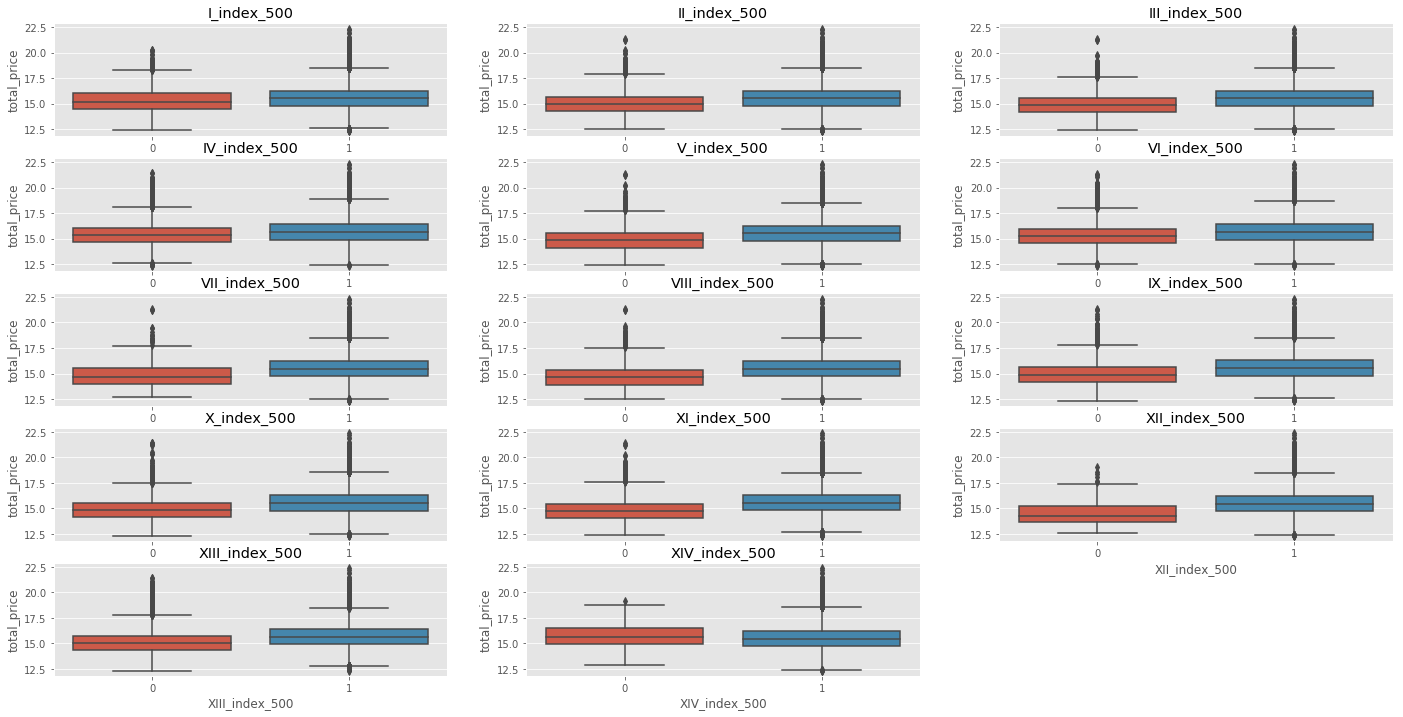

In [28]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_500')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], np.log1p(train['total_price']))

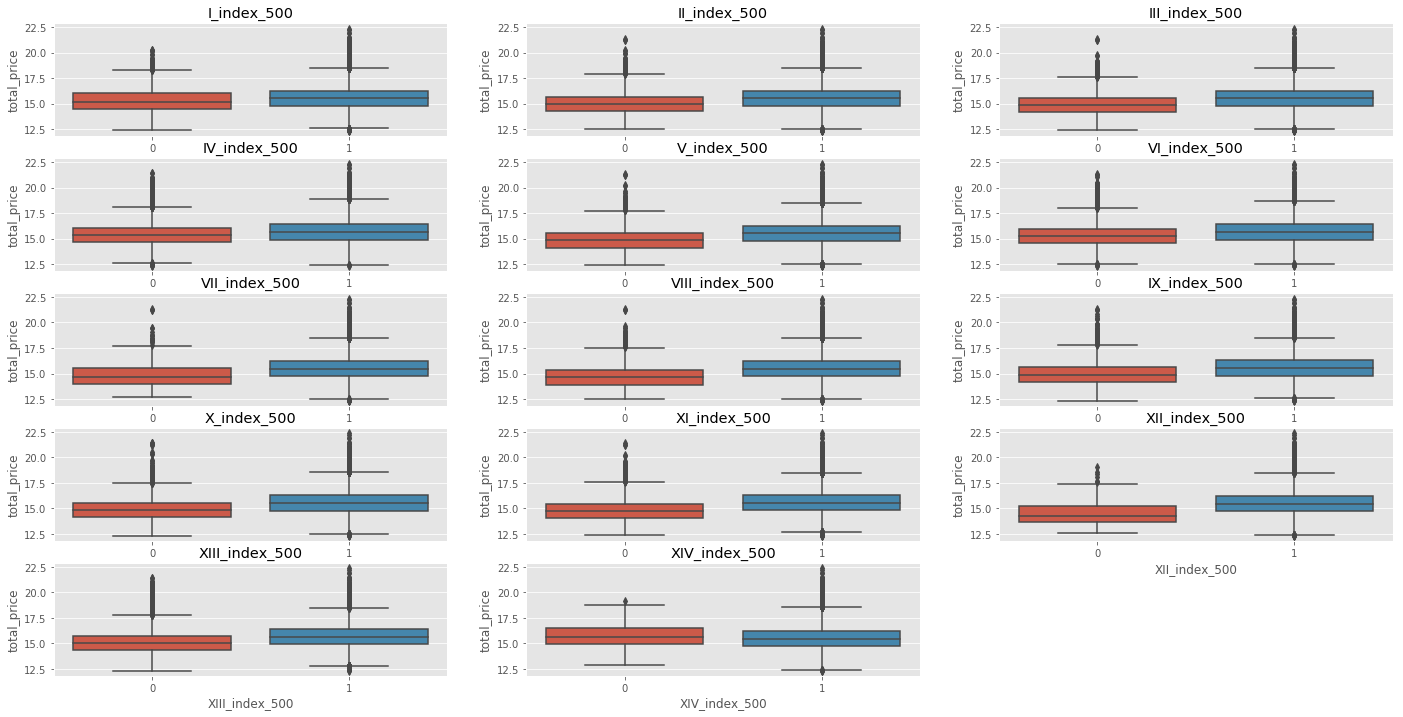

In [29]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_500')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], np.log1p(train['total_price']))

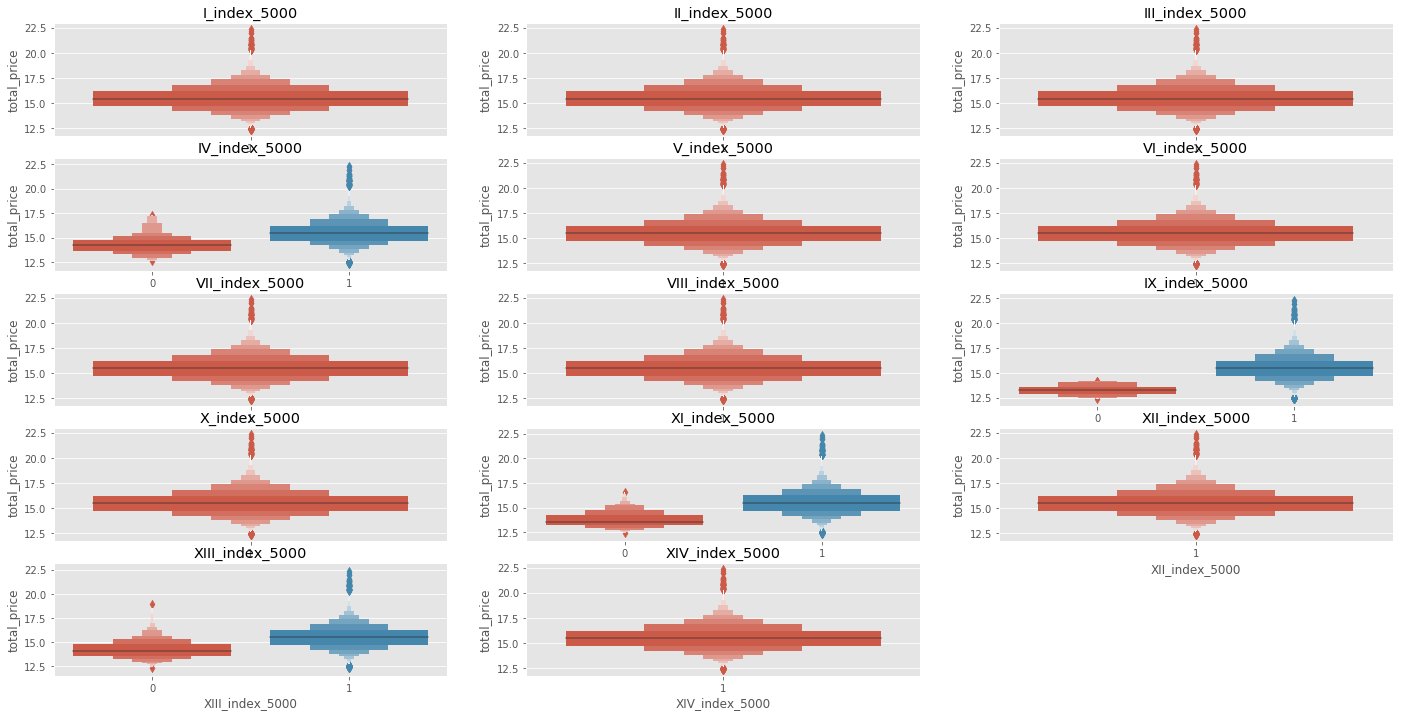

In [30]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_5000')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxenplot(train[col], np.log1p(train['total_price']))

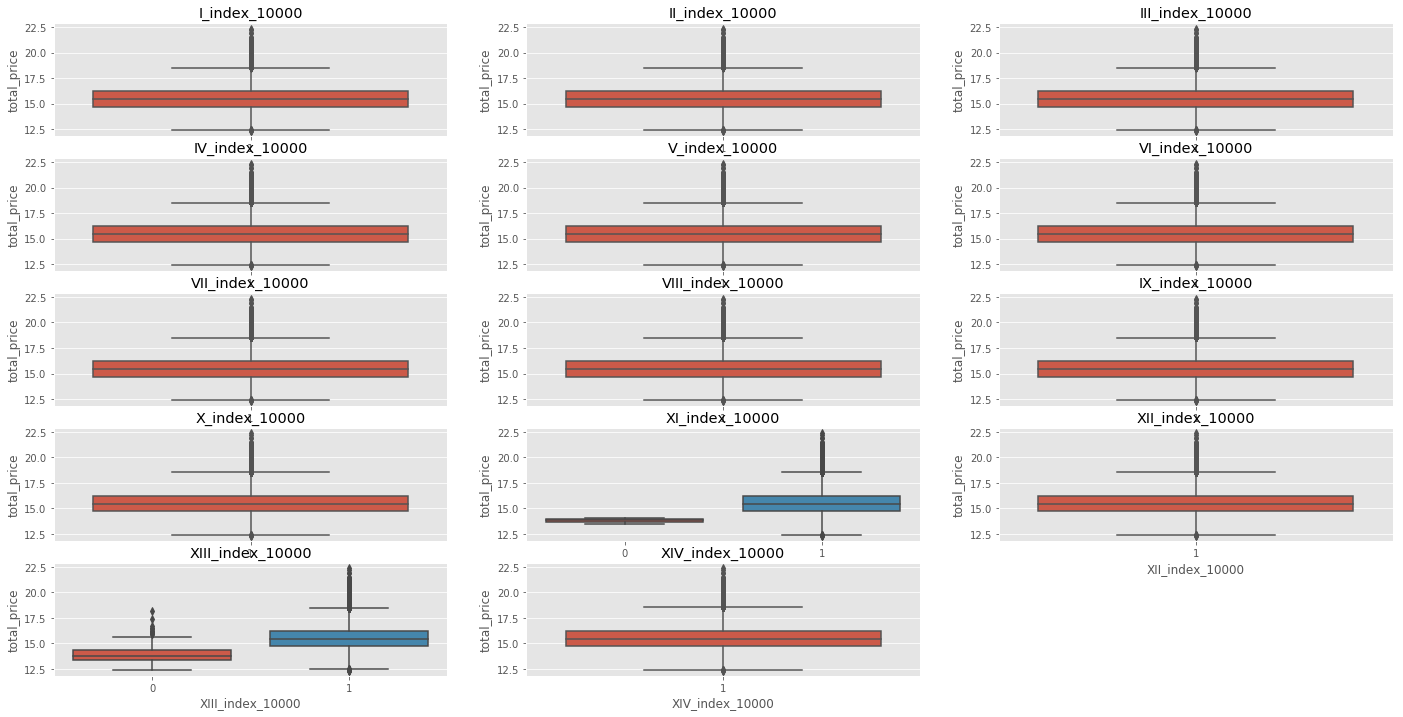

In [31]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_10000')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], np.log1p(train['total_price']))

In [175]:
len([i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i])

22

In [35]:
train['village_income_median'].isna().sum()

1142

In [38]:
train.groupby(['city'])['village_income_median'].median()

city
3     593.0
5     589.0
6     568.0
7     618.0
9     770.0
10    668.0
12    614.0
13    746.0
14    615.0
17    627.0
21    624.0
Name: village_income_median, dtype: float64

In [37]:
train.groupby(['city'])['village_income_median'].mean()

city
3      597.345633
5      588.768020
6      568.731400
7      646.278368
9     1035.359111
10     686.269449
12     635.886657
13     770.654135
14     642.978935
17     630.751546
21     647.720324
Name: village_income_median, dtype: float64

In [40]:
train['village_income_median'].head()

0    572.0
1    550.0
2    625.0
3    950.0
4    536.0
Name: village_income_median, dtype: float64

In [88]:
for city in train['city'].unique():
    print(city)
    temp = train.loc[(train['city'] ==city)]
    high = temp['total_price'].mean() + temp['total_price'].std()
    low  = temp['total_price'].mean() - temp['total_price'].std()
    print(len(temp[(temp['total_price'] > high) | (temp['total_price'] < low)]))
    print('-'*100)

21
148
----------------------------------------------------------------------------------------------------
7
311
----------------------------------------------------------------------------------------------------
12
287
----------------------------------------------------------------------------------------------------
17
25
----------------------------------------------------------------------------------------------------
10
249
----------------------------------------------------------------------------------------------------
13
330
----------------------------------------------------------------------------------------------------
14
143
----------------------------------------------------------------------------------------------------
3
68
----------------------------------------------------------------------------------------------------
6
40
----------------------------------------------------------------------------------------------------
5
28
-----------------------------

In [74]:
train.groupby(['city'])['total_price'].median()

city
3     1.648821e+06
5     1.235981e+06
6     2.585255e+06
7     6.521007e+06
9     4.892756e+06
10    3.321452e+06
12    4.120926e+06
13    1.546996e+07
14    2.727088e+06
17    2.432564e+06
21    2.432520e+06
Name: total_price, dtype: float64

In [19]:
inter_cols = ['building_type', 'parking_way', 'building_use', 'building_material']
for i in range(4):
        for j in range(4):
            if j > i:
                print(i,j)
                
                
                
                
                

0 1
0 2
0 3
1 2
1 3
2 3


In [77]:
len(train.columns)

235

In [84]:
train.groupby(['city'])['building_type'].size()

city
3       813
5      1224
6       826
7     19664
9      1125
10     4676
12     7264
13    10756
14     4704
17      984
21     7964
Name: building_type, dtype: int64

In [28]:
?sns.boxenplot

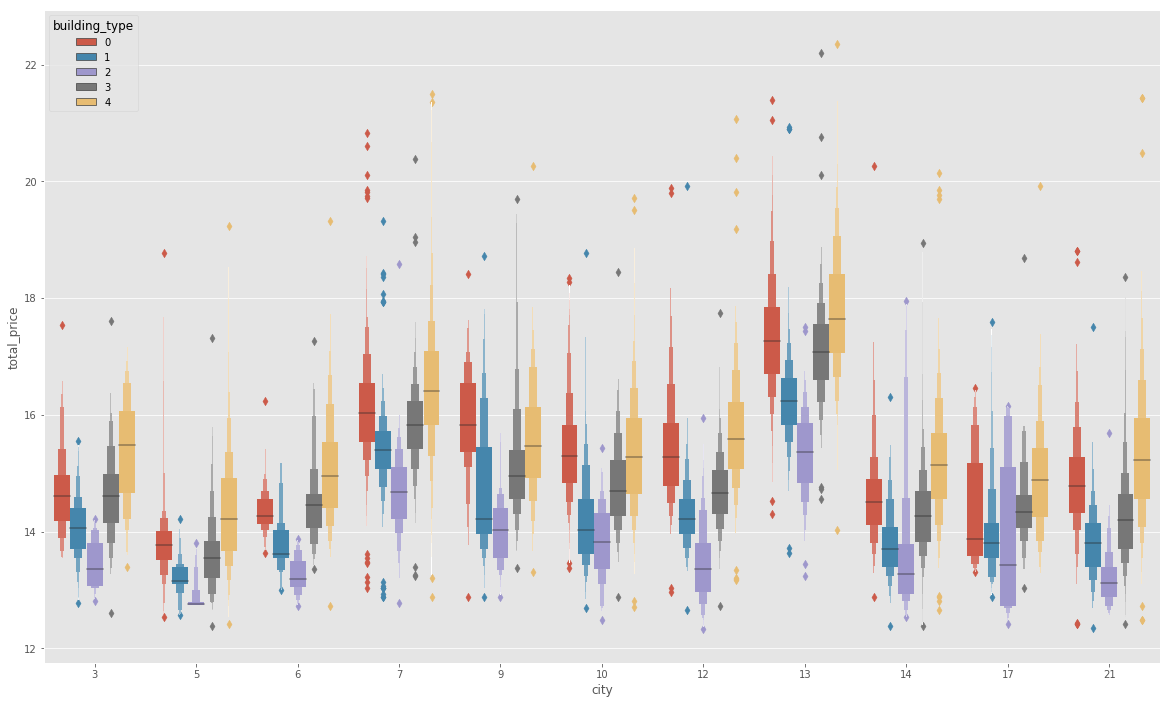

In [32]:
fig = plt.figure(figsize=(20,12))
sns.boxenplot(x = train['city'],y = np.log1p(train['total_price']), hue = train['building_type'])

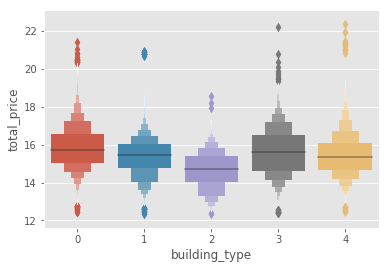

In [4]:
sns.boxenplot(train['building_type'], np.log1p(train['total_price']))

In [19]:
temp = train[train['building_type'] == 4]


In [11]:
train.groupby(['building_type'])['parking_area'].apply(lambda x : x.isna().sum())

building_type
0    13694
1    14957
2     2709
3     9664
4    15873
Name: parking_area, dtype: int64

In [13]:
train.groupby(['building_type'])['land_area'].mean()

building_type
0    12.750181
1    18.255778
2     5.363923
3    16.718784
4    64.492532
Name: land_area, dtype: float64

In [14]:
train.groupby(['building_type'])['land_area'].std()

building_type
0     22.433230
1     11.971430
2      8.446363
3     14.779095
4    105.488234
Name: land_area, dtype: float64

In [15]:
train.groupby(['building_type'])['building_area'].mean()

building_type
0    11.202060
1     5.617327
2     2.419849
3     9.191861
4    15.537716
Name: building_area, dtype: float64

In [16]:
train.groupby(['building_type'])['building_area'].std()

building_type
0    12.830742
1     8.209869
2     6.314876
3    15.273151
4    50.548065
Name: building_area, dtype: float64

In [18]:
test.groupby(['building_type'])['building_area'].mean()

building_type
0    11.364261
1     5.592143
2     2.714495
3     9.259168
4    17.151488
Name: building_area, dtype: float64

In [ ]:
train.groupby(['building_type'])